<a href="https://colab.research.google.com/github/9a24f0/music-classify/blob/cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# MFCC extraction

In [65]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/genres/"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def extract_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

    Params
    ------
        dataset_path (str): Path to dataset
        json_path (str): Path to json file used to save MFCCs
        num_mfcc (int): Number of coefficients to extract
        n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        hop_length (int): Sliding window for FFT. Measured in # of samples
        num_segments (int): Number of segments we want to divide sample tracks into
    """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:

            # save genre label (e.g: pop, blues,..) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
if __name__ == "__main__":  
    extract_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/genres/hiphop/hiphop.00006.wav, segment:8
/content/drive/MyDrive/genres/hiphop/hiphop.00006.wav, segment:9
/content/drive/MyDrive/genres/hiphop/hiphop.00006.wav, segment:10
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:1
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:2
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:3
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:4
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:5
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:6
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:7
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:8
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:9
/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav, segment:10
/content/drive/MyDrive/genres/hiphop/hiphop.00002.wav, segment:1
/content/drive/MyDrive/genres/hiphop/

# Create CNN model and train the data

In [66]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import os
import pickle

import random

DATA_PATH = "data.json"


def load_data(data_path):
    """Loads training dataset from json file.
    Parameters
    ----------
    data_path (str): Path to json file containing data
    
    Returns
    -------
    X (ndarray): Inputs
    y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def prepare_datasets(test_size, validate_size):
    """Loads data and splits it into train, validate and test sets.

    Parameters
    ----------
    test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    validate_size (float): Value in [0, 1] indicating percentage of train set to allocate to validate split
    
    Returns
    -------
    X_train (ndarray): Input training set
    X_validate (ndarray): Input validate set
    X_test (ndarray): Input test set
    y_train (ndarray): Target training set
    y_validate (ndarray): Target validate set
    y_test (ndarray): Target test set
    """

    # load the data set
    X, y = load_data(DATA_PATH)

    # split the data set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=validate_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validate = X_validate[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validate, X_test, y_train, y_validate, y_test


def build_model(ishape):
    """Generates CNN model

    Parameters
    ----------
    ishape (tuple): Shape of input set
    
    Returns
    -------
    model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st convolutional layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=ishape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd convolutional layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd convolutional layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3)) # avoid overfitting

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # splits the dataset into: train, test and validate sets
    # after the split, the train set is 60%, the test set is 25% and the validate set is 15% of the data set
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare_datasets(0.25, 0.2)

    # create CNN
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=32, epochs=42) 

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    print('\nTest loss:', test_loss)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 30, 1, 32)       

# Predict using test set

In [62]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    Parameters
    ----------

    model: Trained classifier
    X: Input data
    y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    return y, predicted_index

def print_predict(number):
    """ Prints random predicts

    Parameters
    ----------
    number: number of samples
    """

    for i in range(10):
      rand = random.randint(0, len(X_test))
      y, predicted_index = predict(model, X_test[rand], y_test[rand])
      print("Target: {}".format(genres[y]))
      print("Predicted label: {}\n".format(genres[predicted_index[0]]))


if __name__ == "__main__":
    # get genre label
    with open(DATA_PATH, "r") as fp:
        data = json.load(fp)

    genres = np.array(data["mapping"])
    
    # print predict for 10 random selected sample
    print_predict(12)



Target: classical
Predicted label: classical

Target: reggae
Predicted label: hiphop

Target: hiphop
Predicted label: reggae

Target: pop
Predicted label: pop

Target: pop
Predicted label: pop

Target: pop
Predicted label: pop

Target: country
Predicted label: country

Target: reggae
Predicted label: disco

Target: pop
Predicted label: disco

Target: classical
Predicted label: classical



# Plot accuracy and loss

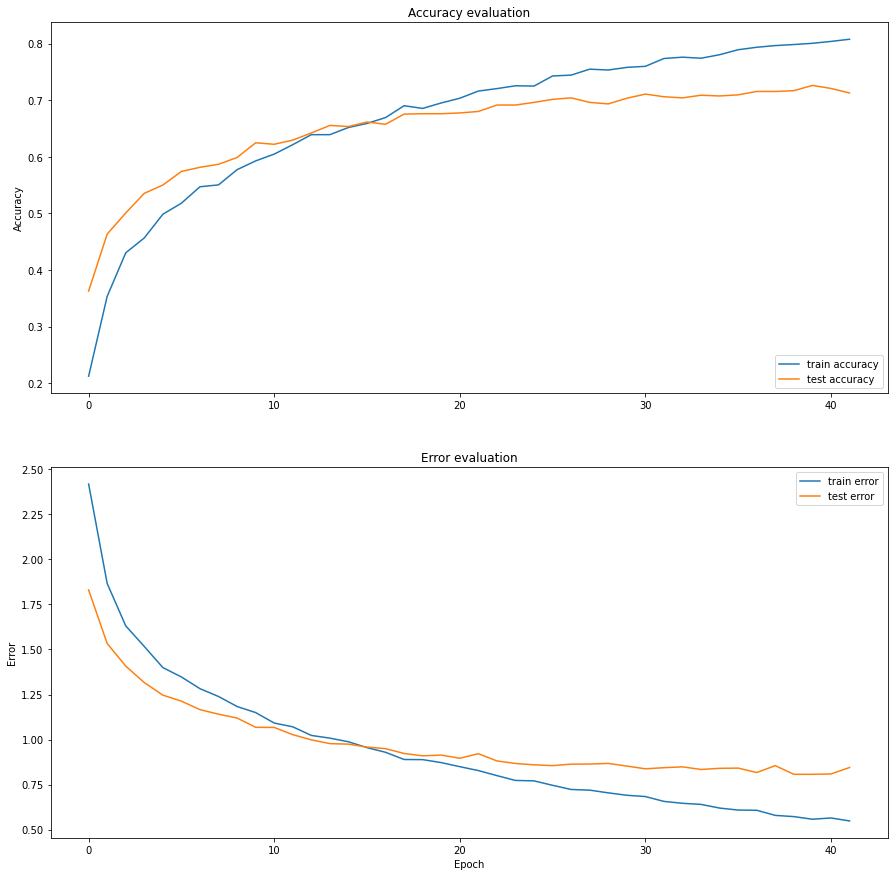

In [52]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

    Parameters
    ----------
    history: Training history of model
    """

    fig, axs = plt.subplots(2, figsize=(15,15))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error evaluation")

    plt.show()


if __name__ == "__main__":
    plot_history(history)

